#### Data can be downloaded [here](https://digital.wpi.edu/concern/student_works/5712m8080?locale=en)
Just scroll to the bottom of the page, download the .zip file into a `Data` directory inside of your parent directory, and unzip it into the `Data` directory!

The sheet you're looking for is `Accuscore Evaluation.xlsx`

In [16]:
# import packages and dataset
import pandas as pd

# These were imported for each fantasy football position type (QB or DST)
QB = pd.read_excel('../Data/Accuscore Evaluation.xlsx', sheet_name='QB Projections')
DST = pd.read_excel('../Data/Accuscore Evaluation.xlsx', sheet_name= 'DST Projections')

# Data Cleaning

In [17]:
# Remove duplicate columns (PLAYERID/ESPNID is simply an alias for PLAYER)
QB = QB.drop(['PLAYERID', 1], axis=1)
# Since defenses are played per team, as long as we have the TEAM data, we know what the name of the player is
DST = DST.drop(['ESPNID', 'PLAYER'], axis=1)
# Rename ORDER column to WEEK for clarity (since order describes the week of the NFL season)
QB = QB.rename(columns={'ORDER':'WEEK'})
DST = DST.rename(columns={'ORDER':'WEEK'})

In [36]:
# Print out the shape of each dataset
print(QB.shape)
print(DST.shape)

(587, 27)
(480, 25)


#### How does the shape of each dataset relate to the number of features and observations in that dataset?
- QBs
    - There are 32 teams in the NFL
    - There were 587 datapoints for projections on 39 different quarterbacks across the 16-week 2013 season (15 games played for each player + 1 bye week)
    - This is because throughout the season, there were injuries to Mark Sanchez, Sam Bradford, Jake Locker, Michael Vick, Aaron Rodgers, and Tony Romo
    - Additionally, Robert Griffin III was benched for Kirk Cousins in the middle of the season
    - Two of these injuries happened in the middle of a game, so there are some weeks with more than 32 'actual' observations in a week
    - Thus, there are 39*15 + 2 = 587 rows in this dataset
- DSTs
    - There are 32 teams, and thus 32 team defenses, in the NFL
    - There are 480 datapoints for projections on these 32 team defeneses across the 16-week 2013 season
    - This is because each team gets a __bye week__ where they don't play. 
    - For defenses, these weeks were excluded from the dataset. Therefore, there are 32 teams * 15 weeks = 480 datapoints
- Features
    - There are 21 projections (16 in-season projections + 5 preseason ones) + a 'variation' column that measures the variance in projections from week to week for each player
    - Other columns track player, team, and week information

In [38]:
# Feature 1: Player/Team
# Expectations included in the description above
print(QB['PLAYER'].describe())
print()
print(DST['TEAM'].describe())
print()

# Feature 2: Actuals (Fantasy points scored)
# I would expect quarterbacks to score, on average, 15 fantasy points. All rows should have a value for this measure
print(QB['Actuals'].describe())
# In actuality, they scored about 13 fantasy points on average, which is lower than I expected.
print()
# I would expect team defenses to score, on average, 8 fantasy points. All rows should have a value for this measure
print(DST['Actuals'].describe())
# In actuality, they scored about 10 fantasy points on average, which is higher than I expected.

count             587
unique             39
top       Andrew Luck
freq               16
Name: PLAYER, dtype: object

count     480
unique     32
top       ATL
freq       15
Name: TEAM, dtype: object

count    587.000000
mean      12.464702
std        9.320537
min       -4.840000
25%        3.680000
50%       12.920000
75%       18.790000
max       39.400000
Name: Actuals, dtype: float64

count    480.000000
mean      10.543750
std        9.213664
min       -4.000000
25%        4.000000
50%        8.000000
75%       15.000000
max       51.000000
Name: Actuals, dtype: float64


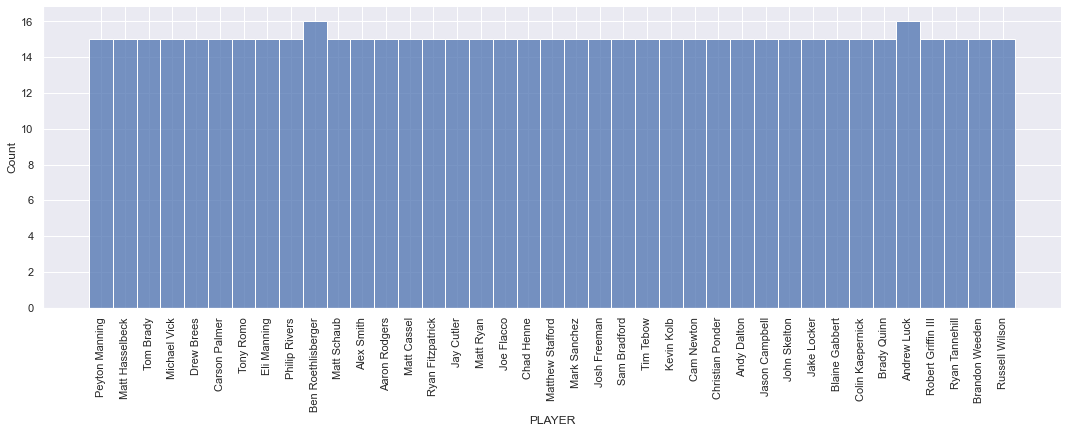

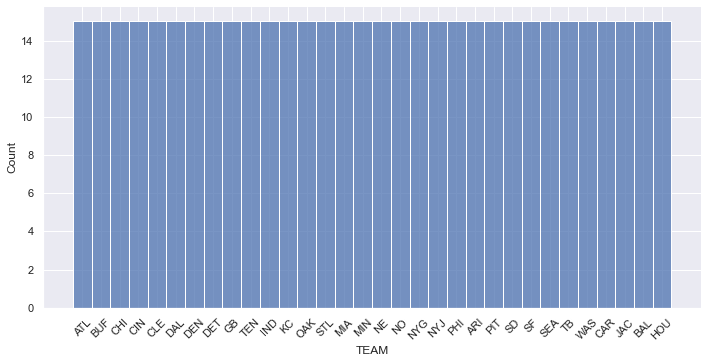

In [75]:
# Figure 1: Player/Team. Histogram of how many observations occur for each player

import seaborn as sns
sns.set_theme()
bar_QBs = sns.displot(data=QB, x='PLAYER', aspect=3)
display(bar_QBs.set_xticklabels(rotation=90))
bar_DSTs = sns.displot(data=DST, x='TEAM', aspect=2)
display(bar_DSTs.set_xticklabels(rotation=45))

# Additional insight: 

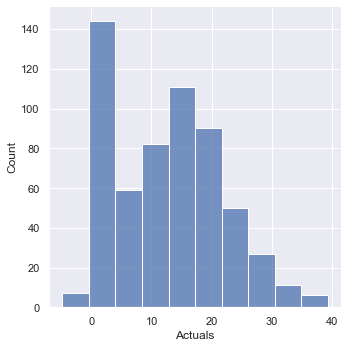

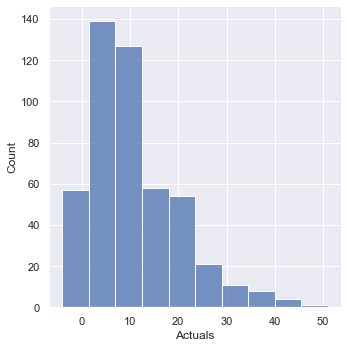

In [78]:
# Figure 2: Fantasy Points Scored. Histogram of how many points each position scores
point_QBs = sns.displot(data=QB, x='Actuals', bins=10)
display(point_QBs)
point_DSTs = sns.displot(data=DST, x='Actuals', bins=10)
display(point_DSTs)